In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE





In [65]:
import chromadb
import pandas as pd

# 1. Verbindung zur DB (Pfad muss stimmen!)
client = chromadb.PersistentClient(path="../VektorDB2")
collection = client.get_collection("VektorDB2")

# 2. Alles auslesen (inklusive Embeddings!)
# Bei ~1700 Chunks geht das problemlos in einem Rutsch.
data = collection.get(include=["embeddings", "metadatas", "documents"])

# 3. DataFrame bauen
# Wir ziehen jetzt 'label' und 'paragraph' zusätzlich raus
df2 = pd.DataFrame({
    'id': data['ids'],
    'text': data['documents'], # Der Inhalt des Chunks
    'embedding': [list(emb) for emb in data['embeddings']], # Vektor als Liste
    
    # Hier holen wir deine Metadaten in eigene Spalten:
    'gesetz': [meta.get('law', 'Unbekannt') for meta in data['metadatas']],
    'label': [meta.get('label', '') for meta in data['metadatas']],        # WICHTIG für Tooltips!
    'paragraph': [meta.get('paragraph', '') for meta in data['metadatas']] # Optional zum Filtern
})

print(f"Anzahl der Embeddings: {len(df2)}")
print("\n--- Vorschau ---")
print(df2[['gesetz', 'label', 'text']].head()) # Zeigt die wichtigsten Spalten

Anzahl der Embeddings: 1675

--- Vorschau ---
  gesetz                       label  \
0    AGG      AGG Präambel/Allgemein   
1    AGG  AGG Präambel/Allgemein (1)   
2    AGG            AGG § 1 (Teil 1)   
3    AGG            AGG § 1 (Teil 2)   
4    AGG                 AGG § 1 (2)   

                                                text  
0  AGG Präambel/Allgemein: Allgemeines Gleichbeha...  
1  AGG Präambel/Allgemein (1): Benachteiligungen ...  
2  AGG § 1 (Teil 1): genannten Grund sind nach Ma...  
3  AGG § 1 (Teil 2): eßlich der Inanspruchnahme d...  
4  AGG § 1 (2): Für Leistungen nach dem Sozialges...  


In [70]:
df2.head()

,id,text,embedding,gesetz,label,paragraph,tsne_x,tsne_y
0,AGG_0,AGG Präambel/Allgemein: Allgemeines Gleichbeha...,"[0.013627409934997559, -0.09008976072072983, 0...",AGG,AGG Präambel/Allgemein,Präambel/Allgemein,-33.630310,24.457739
1,AGG_1,AGG Präambel/Allgemein (1): Benachteiligungen ...,"[-0.05655756965279579, -0.031759168952703476, ...",AGG,AGG Präambel/Allgemein (1),Präambel/Allgemein,-33.312195,18.615387
2,AGG_2,AGG § 1 (Teil 1): genannten Grund sind nach Ma...,"[-0.02275240048766136, -0.03822503983974457, -...",AGG,AGG § 1 (Teil 1),§ 1,-25.627729,24.217585
3,AGG_3,AGG § 1 (Teil 2): eßlich der Inanspruchnahme d...,"[-0.040936581790447235, 0.03495335951447487, 0...",AGG,AGG § 1 (Teil 2),§ 1,-32.025440,25.777517
4,AGG_4,AGG § 1 (2): Für Leistungen nach dem Sozialges...,"[-0.08673602342605591, 0.08773958683013916, 0....",AGG,AGG § 1 (2),§ 1,-36.216537,10.535435


In [71]:
df2.isnull().sum()

id           0
text         0
embedding    0
gesetz       0
label        0
paragraph    0
tsne_x       0
tsne_y       0
dtype: int64

In [72]:
embeddings_matrix = np.array(data['embeddings'])
print(embeddings_matrix.shape)
embeddings_matrix[0:5][:5]  # Zeige die ersten 5 Werte des ersten Embeddings



(1675, 1024)


array([[ 0.01362741, -0.09008976,  0.11728039, ...,  0.01995625,
        -0.01408669, -0.03276968],
       [-0.05655757, -0.03175917,  0.03478821, ...,  0.01591629,
        -0.01714976, -0.03932549],
       [-0.0227524 , -0.03822504, -0.00270841, ..., -0.00501187,
        -0.0019359 , -0.00868686],
       [-0.04093658,  0.03495336,  0.09225354, ..., -0.00661717,
        -0.02098869, -0.01347421],
       [-0.08673602,  0.08773959,  0.04217771, ...,  0.0033426 ,
        -0.01600457, -0.02431257]], shape=(5, 1024))

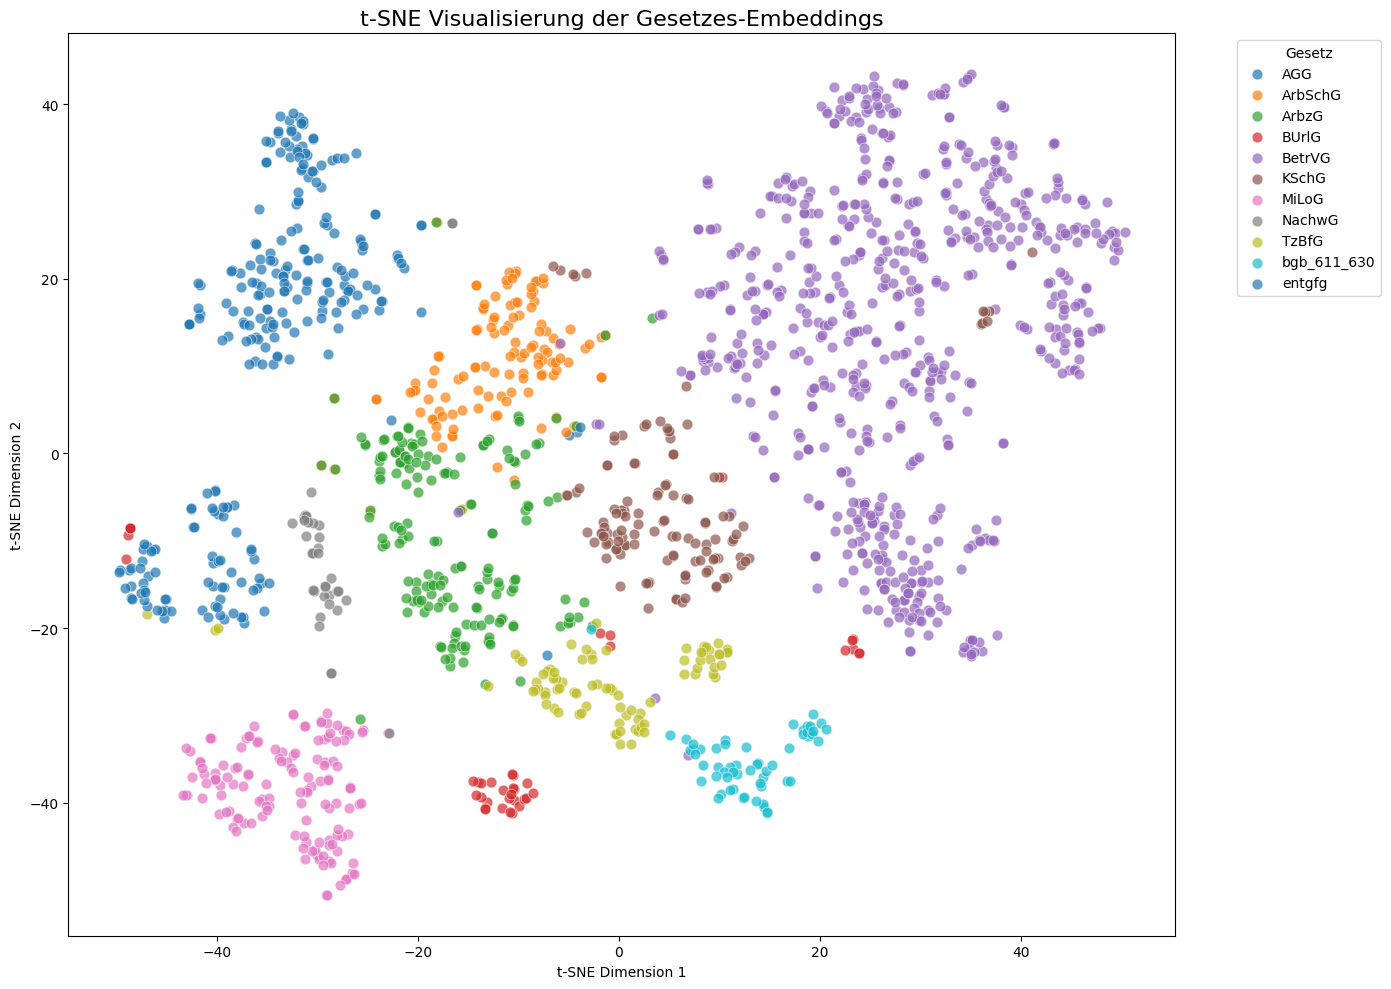

In [76]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# 1. Matrix für t-SNE vorbereiten (Liste von Listen in Numpy-Array wandeln)
embeddings_matrix = np.array(df2['embedding'].tolist())

# 2. t-SNE Berechnung
# (Perplexity=30 ist gut, bei kleineren Datenmengen (<500 Punkte) evtl. auf 5-10 senken)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_matrix)

# 3. Koordinaten zurück in den DataFrame
df2['tsne_x'] = embeddings_2d[:, 0]
df2['tsne_y'] = embeddings_2d[:, 1]

# 4. Visualisierung mit korrekter Legende
plt.figure(figsize=(14, 10))

# Wir loopen durch die Gesetze, damit jedes seine eigene Farbe und Label in der Legende bekommt
groups = df2.groupby('gesetz')
for name, group in groups:
    plt.scatter(group['tsne_x'], group['tsne_y'], 
                label=name,       # Das sorgt für den Namen in der Legende
                alpha=0.7,        # Leicht transparent
                s=60,             # Punktgröße
                edgecolors='w',   # Weißer Rand macht die Punkte schärfer
                linewidth=0.5)

plt.title('t-SNE Visualisierung der Gesetzes-Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Legende hübsch machen
plt.legend(title="Gesetz", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

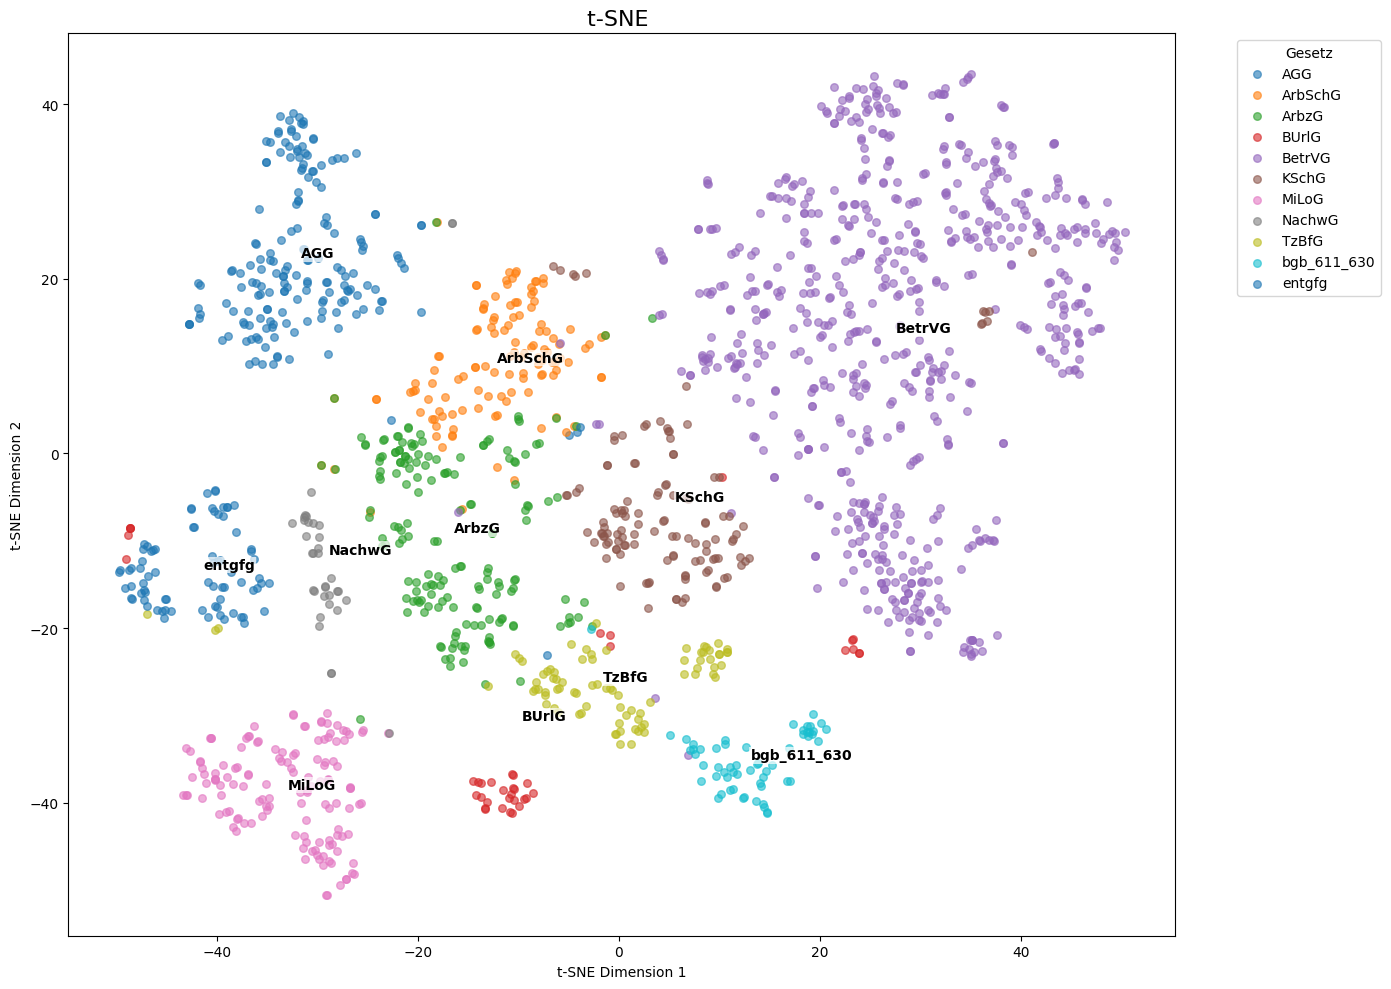

In [86]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# 1. Daten vorbereiten (Wichtig: explizit in Numpy-Array wandeln)
embeddings_matrix = np.array(df2['embedding'].tolist())

# 2. t-SNE berechnen
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_matrix)

df2['tsne_x'] = embeddings_2d[:, 0]
df2['tsne_y'] = embeddings_2d[:, 1]

# 3. Visualisierung
plt.figure(figsize=(14, 10))

# Wir iterieren durch die Gesetze -> Das gibt uns automatisch die Farben und die Legende
groups = df2.groupby('gesetz')

for name, group in groups:
    plt.scatter(group['tsne_x'], group['tsne_y'], 
                label=name,       # Name für die Legende
                alpha=0.6, 
                s=30)             # Punktgröße etwas kleiner für Übersichtlichkeit

# 4. INTELLIGENTE LABELS: Nur den Schwerpunkt (Mitte) beschriften
# Das verhindert, dass der Plot unlesbar wird
for name, group in groups:
    # Berechne die Mitte der Wolke
    center_x = group['tsne_x'].mean()
    center_y = group['tsne_y'].mean()
    
    # Schreibe den Namen nur einmal an diese Stelle
    plt.text(center_x, center_y, 
             name, 
             fontsize=10, 
             fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.title('t-SNE ', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Legende außerhalb platzieren, damit sie nicht stört
plt.legend(title="Gesetz", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

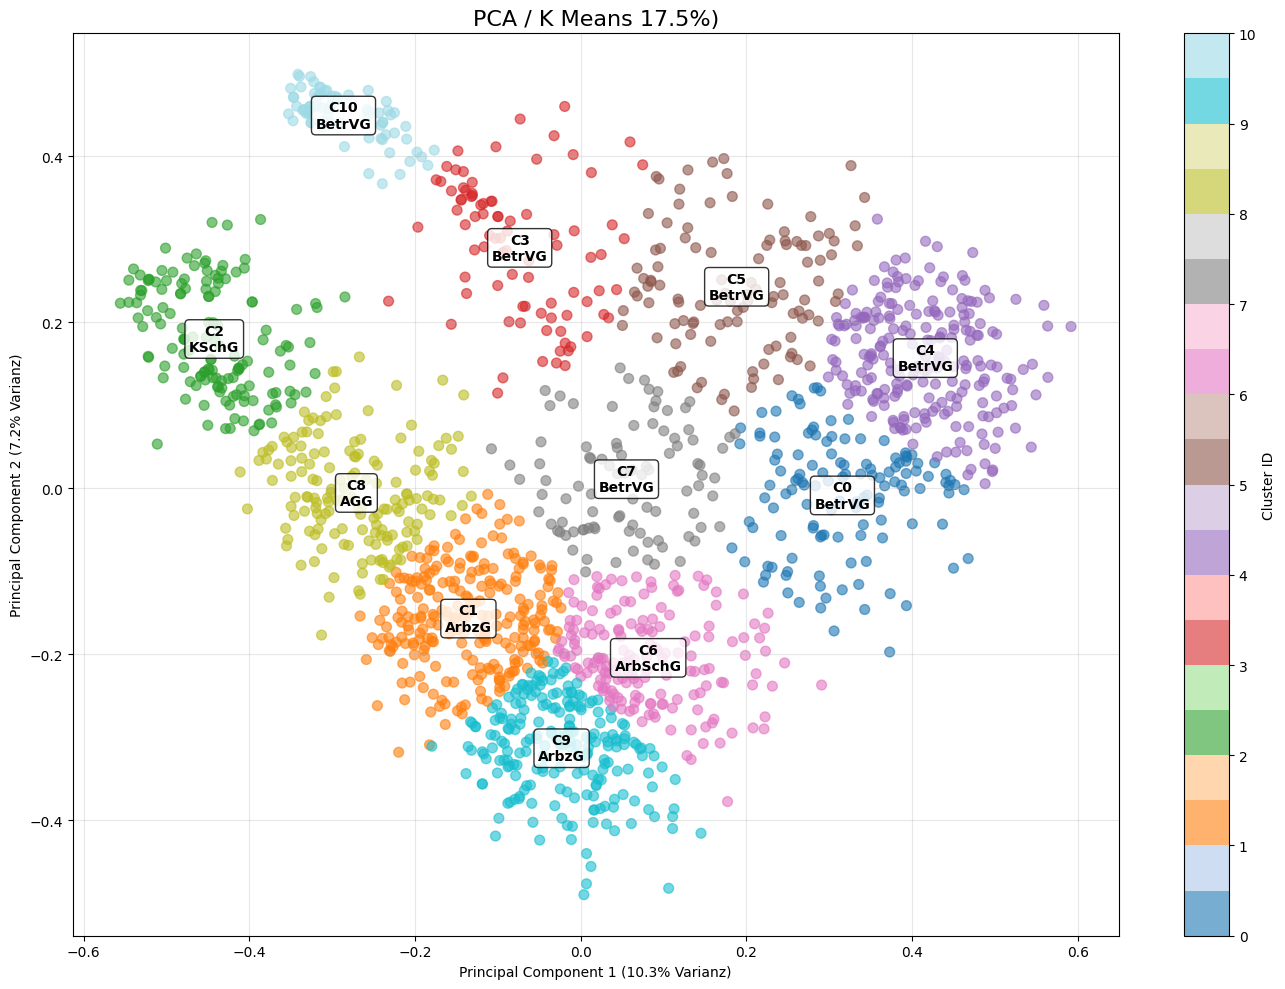


--- Analyse der PCA-Cluster Reinheit ---
PCA-Cluster 0: Dominant 'BetrVG' (84.5%)
PCA-Cluster 1: Dominant 'ArbzG' (18.7%)
PCA-Cluster 2: Dominant 'KSchG' (21.2%)
PCA-Cluster 3: Dominant 'BetrVG' (97.7%)
PCA-Cluster 4: Dominant 'BetrVG' (100.0%)
PCA-Cluster 5: Dominant 'BetrVG' (99.1%)
PCA-Cluster 6: Dominant 'ArbSchG' (28.2%)
PCA-Cluster 7: Dominant 'BetrVG' (50.5%)
PCA-Cluster 8: Dominant 'AGG' (26.1%)
PCA-Cluster 9: Dominant 'ArbzG' (23.3%)
PCA-Cluster 10: Dominant 'BetrVG' (100.0%)


In [87]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Annahme: df2 und embeddings_matrix existieren bereits aus den vorherigen Schritten
# Falls nicht: embeddings_matrix = np.array(df2['embedding'].tolist())

# 1. PCA durchführen (Reduktion auf 2 Hauptkomponenten)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_matrix)

# Die Koordinaten im DataFrame speichern
df2['pca_x'] = pca_result[:, 0]
df2['pca_y'] = pca_result[:, 1]

# 2. K-Means AUF DEN PCA-DATEN rechnen
# Das ist "K-Means nach PCA". Wir clustern die 2D-Punkte.
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df2['cluster_pca'] = kmeans.fit_predict(pca_result)

# 3. Visualisierung
plt.figure(figsize=(14, 10))

# Scatter Plot: Farbe = Cluster (was der Algorithmus gefunden hat)
# Wir nutzen PC1 und PC2 als Achsen
scatter = plt.scatter(df2['pca_x'], df2['pca_y'], 
                      c=df2['cluster_pca'], 
                      cmap='tab20', 
                      alpha=0.6, 
                      s=50)

# 4. Feature: Automatische Beschriftung der Cluster-Zentren mit dem häufigsten Gesetz
# Wir nutzen die Cluster-IDs aus dem PCA-K-Means
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_pca'] == i]
    
    if len(cluster_data) == 0:
        continue
        
    # a) Berechne den Mittelpunkt (Schwerpunkt) im PCA-Raum
    center_x = cluster_data['pca_x'].mean()
    center_y = cluster_data['pca_y'].mean()
    
    # b) Finde das dominanteste Gesetz in diesem Cluster (Ground Truth Check)
    top_law = cluster_data['gesetz'].value_counts().idxmax()
    
    # Label erstellen
    label_text = f"C{i}\n{top_law}"
    
    # c) Text zeichnen
    plt.text(center_x, center_y, 
             label_text, 
             fontsize=10, 
             fontweight='bold', 
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# Achsenbeschriftung und Titel
# Wichtig: Bei PCA sagt man "Principal Component 1" (erklärt am meisten Varianz)
var_explained = pca.explained_variance_ratio_
plt.title(f'PCA / K Means {sum(var_explained):.1%})', fontsize=16)
plt.xlabel(f'Principal Component 1 ({var_explained[0]:.1%} Varianz)')
plt.ylabel(f'Principal Component 2 ({var_explained[1]:.1%} Varianz)')

plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster ID')
plt.grid(True, alpha=0.3) # Gitter hilft bei PCA oft zur Orientierung
plt.tight_layout()
plt.show()

# 5. Statistik: Wie sauber sind die PCA-Cluster?
print("\n--- Analyse der PCA-Cluster Reinheit ---")
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_pca'] == i]
    if len(cluster_data) == 0: continue
    
    top_law_stats = cluster_data['gesetz'].value_counts()
    dominant_law = top_law_stats.index[0]
    percentage = (top_law_stats.iloc[0] / len(cluster_data)) * 100
    
    print(f"PCA-Cluster {i}: Dominant '{dominant_law}' ({percentage:.1f}%)")

In [88]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 7.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 7.9 MB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [umap-learn]4 [pynndescent]
Note: you may need to restart the kernel to use updated packages.


/Users/perezopoku/Desktop/Programme/Persönlcihe Projekte/RAG/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


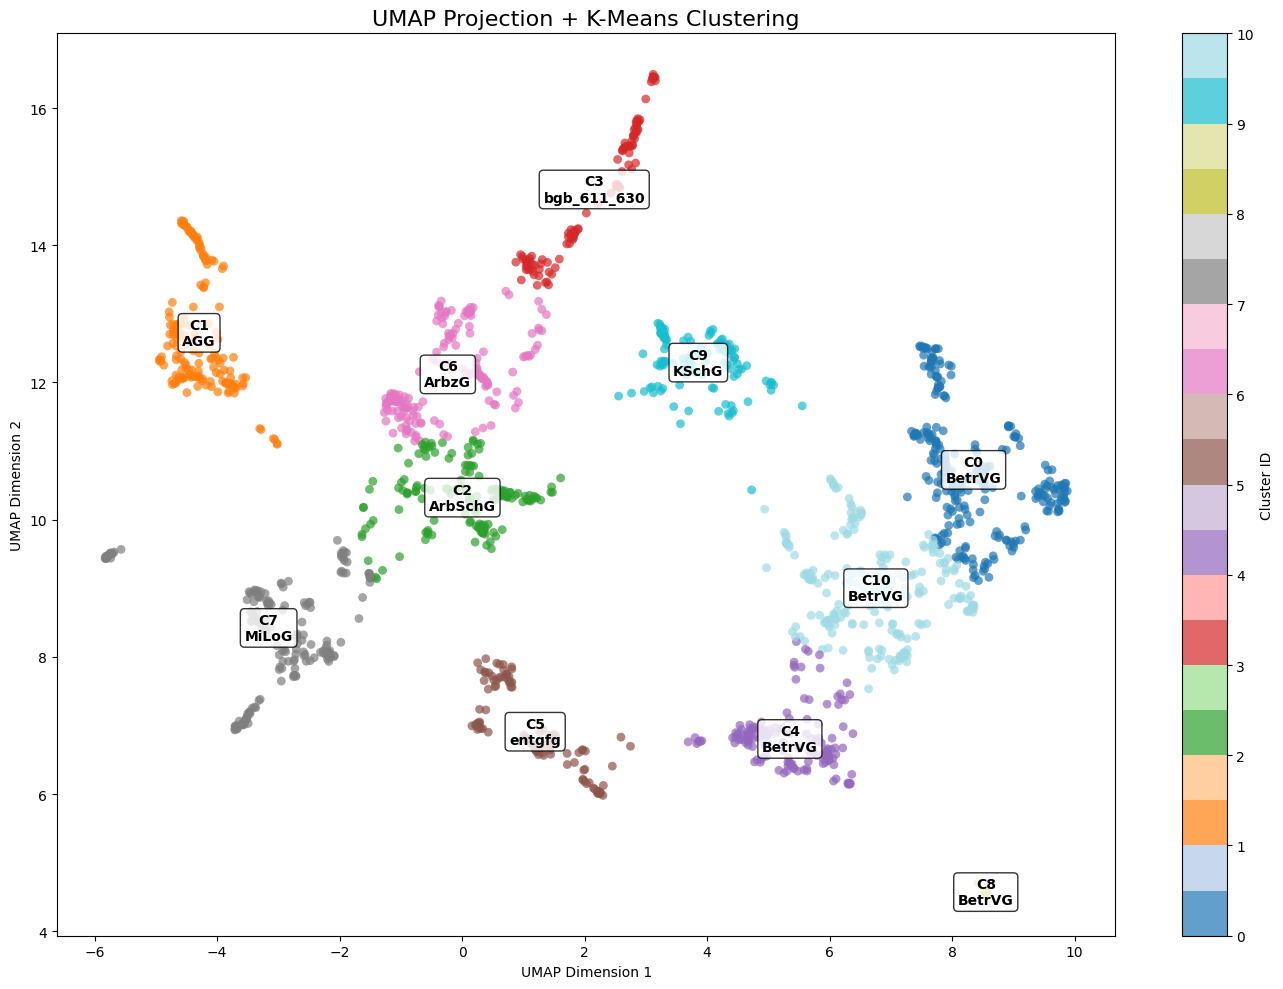


--- Analyse der UMAP-Cluster Reinheit ---
UMAP-Cluster 0: Dominant 'BetrVG' (99.6%)
UMAP-Cluster 1: Dominant 'AGG' (97.7%)
UMAP-Cluster 2: Dominant 'ArbSchG' (70.2%)
UMAP-Cluster 3: Dominant 'bgb_611_630' (52.3%)
UMAP-Cluster 4: Dominant 'BetrVG' (94.8%)
UMAP-Cluster 5: Dominant 'entgfg' (68.1%)
UMAP-Cluster 6: Dominant 'ArbzG' (84.8%)
UMAP-Cluster 7: Dominant 'MiLoG' (73.7%)
UMAP-Cluster 8: Dominant 'BetrVG' (100.0%)
UMAP-Cluster 9: Dominant 'KSchG' (96.7%)
UMAP-Cluster 10: Dominant 'BetrVG' (99.1%)


In [90]:
import umap.umap_ as umap  # pip install umap-learn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. UMAP Reduktion durchführen (auf 2 Dimensionen)
# n_neighbors: Balance zwischen lokaler und globaler Struktur (15-50 ist gut)
# min_dist: Wie eng dürfen Punkte zusammenrücken (0.1 ist standard)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = reducer.fit_transform(embeddings_matrix)

# Koordinaten speichern
df2['umap_x'] = umap_result[:, 0]
df2['umap_y'] = umap_result[:, 1]

# 2. K-Means auf den UMAP-Koordinaten rechnen
# Wir clustern direkt die 2D-Projektion, damit die Farben perfekt zu den Inseln passen
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df2['cluster_umap'] = kmeans.fit_predict(umap_result)

# 3. Visualisierung
plt.figure(figsize=(14, 10))

# Scatter Plot
scatter = plt.scatter(df2['umap_x'], df2['umap_y'], 
                      c=df2['cluster_umap'], 
                      cmap='tab20', # Große Farbpalette für 11 Cluster
                      alpha=0.7, 
                      s=40,
                      edgecolors='none')

# 4. Feature: Automatische Beschriftung der Cluster-Zentren (Dominantes Gesetz)
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_umap'] == i]
    
    if len(cluster_data) == 0:
        continue
        
    # Schwerpunkt im UMAP-Raum berechnen
    center_x = cluster_data['umap_x'].mean()
    center_y = cluster_data['umap_y'].mean()
    
    # Häufigstes Gesetz in diesem Cluster finden
    top_law_stats = cluster_data['gesetz'].value_counts()
    top_law = top_law_stats.idxmax()
    count = top_law_stats.iloc[0]
    
    # Label erstellen (z.B. "KSchG")
    label_text = f"C{i}\n{top_law}"
    
    # Text zeichnen (mit weißer Box für Lesbarkeit)
    plt.text(center_x, center_y, 
             label_text, 
             fontsize=10, 
             fontweight='bold', 
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

# Titel und Achsen
plt.title('UMAP Projection + K-Means Clustering', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster ID')
plt.tight_layout()
plt.show()

# 5. Statistik: Wie rein sind die UMAP-Inseln?
print("\n--- Analyse der UMAP-Cluster Reinheit ---")
for i in range(n_clusters):
    cluster_data = df2[df2['cluster_umap'] == i]
    if len(cluster_data) == 0: continue
    
    top_law_stats = cluster_data['gesetz'].value_counts()
    dominant_law = top_law_stats.index[0]
    percentage = (top_law_stats.iloc[0] / len(cluster_data)) * 100
    
    print(f"UMAP-Cluster {i}: Dominant '{dominant_law}' ({percentage:.1f}%)")

In [ ]:
from dotenv import load_dotenv, dotenv_values
import os

load_dotenv("../key.env")
jinaai_api_key = os.getenv("JINAAI_API_KEY")

#print(os.getenv("JINAAI_API_KEY"))

jina_bb483ebd00864375b15006142b24dd4eE_J10jjwPo8uN8b66zwpQJS11Nkh


In [93]:
query_embed_model = JinaEmbedding(
    api_key=jinaai_api_key,
    model="jina-embeddings-v3",
    task="retrieval.query" 
)





In [94]:
def search_law(query_text, top_k=5):
    """
    Sucht die relevantesten Gesetzes-Chunks für eine Frage.
    """
    print(f"Suche nach: '{query_text}'...")
    
    # A) Frage in Vektor umwandeln
    query_vector = query_embed_model.get_text_embedding(query_text)
    
    # B) Datenbank abfragen
    results = collection.query(
        query_embeddings=[query_vector],
        n_results=top_k,
        include=["metadatas", "documents", "distances"]
    )
    
    # C) Ergebnisse hübsch aufbereiten
    hits = []
    # Chroma gibt Listen von Listen zurück (wegen Batch-Support), daher [0]
    for i in range(len(results['ids'][0])):
        hits.append({
            'Score': results['distances'][0][i], # Kleiner ist besser (bei L2 Distanz)
            'Gesetz': results['metadatas'][0][i].get('gesetz'),
            'Label': results['metadatas'][0][i].get('label'),
            'Inhalt': results['documents'][0][i]
        })
    
    return pd.DataFrame(hits)

In [95]:
df_result = search_law("Wie viel Urlaub steht mir mindestens zu?")
print(df_result[['Label', 'Score', 'Inhalt']].head())

print("\n" + "="*50 + "\n")

# Beispiel 2: Kündigung
df_result2 = search_law("Was passiert wenn ich krank bin und gekündigt werde?")
print(df_result2[['Label', 'Score', 'Inhalt']].head())

Suche nach: 'Wie viel Urlaub steht mir mindestens zu?'...
                      Label     Score  \
0            BUrlG § 12 (1)  0.811614   
1            BUrlG § 12 (2)  0.916405   
2            BUrlG § 12 (1)  1.005150   
3            BUrlG § 12 (2)  1.016449   
4  BUrlG Präambel/Allgemein  1.033279   

                                              Inhalt  
0  BUrlG § 12 (1): Der Urlaub beträgt jährlich mi...  
1  BUrlG § 12 (2): Der Urlaub ist zusammenhängend...  
2  BUrlG § 12 (1): Anspruch auf ein Zwölftel des ...  
3  BUrlG § 12 (2): Als Werktage gelten alle Kalen...  
4  BUrlG Präambel/Allgemein: Mindesturlaubsgesetz...  


Suche nach: 'Was passiert wenn ich krank bin und gekündigt werde?'...
                           Label     Score  \
0                  BUrlG § 5 (4)  1.161138   
1                    entgfg § 10  1.249165   
2  entgfg Präambel/Allgemein (1)  1.251702   
3                 entgfg § 6 (1)  1.268210   
4                  KSchG § 2 (1)  1.282701   

                